# Analysis Using Causal Graphs

In [15]:
%pip install networkx matplotlib dowhy pandas seaborn 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import openai
import sys
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from dowhy import CausalModel
import os
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import warnings

plt.style.use('ggplot')
PATH_TO_ESTIMATION_METHODS = 'estimation_methods'
sys.path.append(os.path.abspath(PATH_TO_ESTIMATION_METHODS))
np.random.seed(42)  
warnings.simplefilter(action='ignore', category=FutureWarning)

Loading The Datasets

In [17]:
df_parent_folder = "data/processed" 
dfs = {}
with os.scandir(df_parent_folder) as entires:
    for entry in entires:
        if entry.is_file() and entry.name.endswith(".csv"):
            name = entry.name.split('/')[-1]
            #print(name)
            dfs[name] = pd.read_csv(entry.path)
# print(list(dfs.keys()))
# print(len(dfs))

# Building The Causal Graphs

### GPT - graphs

In [18]:
"""
We used the following prompt:
Please construct the causal graph of the following variables where "Target"= Success in academic program. Please include beforehand the causal relation "Adult" -> "Target. Provide the answer in doi format for suitable for the DoWhy framework:

['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Mother's qualification',
       'Father's qualification', 'Mother's occupation', 'Father's occupation',
       'Admission grade', 'Displaced', 'Educational special needs', 'Gender',
       'Scholarship holder', 'Unemployment rate', 'Inflation rate', 'GDP',
       'Target', 'Adult']
"""
model_edges = {}
model_edges["gpt-o3-mini-high"] = """
digraph {

  "GDP" -> "Adult";
  "GDP" -> "Scholarship holder";
  "GDP" -> "Mother's qualification";
  "GDP" -> "Father's qualification";
  "GDP" -> "Mother's occupation";
  "GDP" -> "Father's occupation";
  "Unemployment rate" -> "Adult";
  "Unemployment rate" -> "Scholarship holder";
  "Inflation rate" -> "Adult";
  "Inflation rate" -> "Scholarship holder";
  "Gender" -> "Adult";
  "Gender" -> "Previous qualification";
  "Gender" -> "Application mode";
  "Gender" -> "Course";
  "Marital status" -> "Adult";
  "Marital status" -> "Daytime/evening attendance";
  "Mother's qualification" -> "Previous qualification";
  "Father's qualification" -> "Previous qualification";
  "Mother's qualification" -> "Adult";
  "Father's qualification" -> "Adult";
  "Mother's occupation" -> "Previous qualification";
  "Father's occupation" -> "Previous qualification";
  "Mother's occupation" -> "Admission grade";
  "Father's occupation" -> "Admission grade";
  "Previous qualification" -> "Previous qualification (grade)";
  "Previous qualification" -> "Admission grade";
  "Previous qualification (grade)" -> "Course";
  "Displaced" -> "Previous qualification";
  "Educational special needs" -> "Previous qualification (grade)";
  "Educational special needs" -> "Target";
  "Application mode" -> "Application order";
  "Application mode" -> "Admission grade";
  "Application order" -> "Admission grade";
  "Daytime/evening attendance" -> "Admission grade";
  "Admission grade" -> "Target";
  "Course" -> "Target";
  "Scholarship holder" -> "Target";
  "Adult" -> "Application mode";
  "Adult" -> "Application order";
  "Adult" -> "Previous qualification";
  "Adult" -> "Course";
  "Adult" -> "Target";
}

"""
model_edges["gpt-o1"] = """
digraph {
  "Mother's qualification" -> "Adult";
  "Mother's qualification" -> "Target";
  "Father's qualification" -> "Adult";
  "Father's qualification" -> "Target";
  "GDP" -> "Adult";
  "GDP" -> "Target";
  "Gender" -> "Adult";
  "Gender" -> "Target";
  "Marital status" -> "Adult";
  "Marital status" -> "Target";
  "Mother's occupation" -> "Adult";
  "Mother's occupation" -> "Admission grade";
  "Mother's occupation" -> "Target";
  "Father's occupation" -> "Adult";
  "Father's occupation" -> "Admission grade";
  "Father's occupation" -> "Target";
  "Unemployment rate" -> "Adult";
  "Unemployment rate" -> "Scholarship holder";
  "Unemployment rate" -> "Target";
  "Inflation rate" -> "Adult";
  "Inflation rate" -> "Scholarship holder";
  "Inflation rate" -> "Target";
  "Adult" -> "Target";
  "Adult" -> "Application mode";
  "Adult" -> "Application order";
  "Adult" -> "Previous qualification";
  "Adult" -> "Daytime/evening attendance";
  "Adult" -> "Course";
  "Displaced" -> "Previous qualification";
  "Displaced" -> "Educational special needs";
  "Gender" -> "Application mode";
  "Gender" -> "Course";
  "Gender" -> "Previous qualification";
  "Gender" -> "Admission grade";
  "Mother's qualification" -> "Previous qualification";
  "Father's qualification" -> "Previous qualification";
  "Previous qualification" -> "Previous qualification (grade)";
  "Previous qualification" -> "Admission grade";
  "Previous qualification" -> "Course";
  "Previous qualification (grade)" -> "Admission grade";
  "Educational special needs" -> "Previous qualification (grade)";
  "Educational special needs" -> "Target";
  "Application mode" -> "Application order";
  "Application mode" -> "Admission grade";
  "Application order" -> "Admission grade";
  "Marital status" -> "Daytime/evening attendance";
  "Daytime/evening attendance" -> "Target";
  "Admission grade" -> "Target";
  "Course" -> "Target";
  "Scholarship holder" -> "Target";
  "GDP" -> "Mother's qualification";
  "GDP" -> "Father's qualification";
  "GDP" -> "Mother's occupation";
  "GDP" -> "Father's occupation";
  "Unemployment rate" -> "Scholarship holder";
  "Inflation rate" -> "Scholarship holder";
}

"""
model_edges["gpt-o4"] = """
digraph {
    "Adult" -> "Target";
    "Marital status" -> "Target";
    "Application mode" -> "Target";
    "Application order" -> "Target";
    "Course" -> "Target";
    "Daytime/evening attendance" -> "Target";
    "Previous qualification" -> "Target";
    "Previous qualification (grade)" -> "Target";
    "Mother's qualification" -> "Target";
    "Father's qualification" -> "Target";
    "Mother's occupation" -> "Target";
    "Father's occupation" -> "Target";
    "Admission grade" -> "Target";
    "Displaced" -> "Target";
    "Educational special needs" -> "Target";
    "Gender" -> "Target";
    "Scholarship holder" -> "Target";
    "Unemployment rate" -> "Target";
    "Inflation rate" -> "Target";
    "GDP" -> "Target";

    "Marital status" -> "Adult";
    "Application mode" -> "Admission grade";
    "Application order" -> "Admission grade";
    "Course" -> "Daytime/evening attendance";
    "Previous qualification" -> "Previous qualification (grade)";
    "Mother's qualification" -> "Mother's occupation";
    "Father's qualification" -> "Father's occupation";
    "Mother's qualification" -> "Previous qualification";
    "Father's qualification" -> "Previous qualification";
    "Mother's occupation" -> "Previous qualification";
    "Father's occupation" -> "Previous qualification";
    "Previous qualification (grade)" -> "Admission grade";
    "Admission grade" -> "Scholarship holder";
    "Unemployment rate" -> "Scholarship holder";
    "Inflation rate" -> "Scholarship holder";
    "GDP" -> "Scholarship holder";
}
"""

# Gemini's output
# edges_flash2 = {("Marital status", "Finished successfully"), ("Application mode", "Application order"), ("Application mode", "Course"), ("Application mode", "Daytime/evening attendance"), ("Application mode", "Previous qualification"), ("Application mode", "Admission grade"), ("Application mode", "Scholarship holder"), ("Application order", "Course"), ("Course", "Finished successfully"), ("Daytime/evening attendance", "Finished successfully"), ("Previous qualification", "Previous qualification (grade)"), ("Previous qualification", "Admission grade"), ("Previous qualification (grade)", "Admission grade"), ("Mother's qualification", "Father's qualification"), ("Mother's qualification", "Admission grade"), ("Father's qualification", "Admission grade"), ("Mother's occupation", "Father's occupation"), ("Mother's occupation", "Admission grade"), ("Father's occupation", "Admission grade"), ("Admission grade", "Finished successfully"), ("Displaced", "Finished successfully"), ("Educational special needs", "Finished successfully"), ("Gender", "Finished successfully"), ("Scholarship holder", "Finished successfully"), ("Unemployment rate", "GDP"), ("Unemployment rate", "Inflation rate"), ("Inflation rate", "GDP"), ("GDP", "Finished successfully"), ("Adult", "Finished successfully")}
# edges_flash2_think = {("Mother's qualification", "Previous qualification"), ("Father's qualification", "Previous qualification"), ("Mother's occupation", "Previous qualification"), ("Father's occupation", "Previous qualification"), ("Mother's qualification", "Previous qualification (grade)"), ("Father's qualification", "Previous qualification (grade)"), ("Mother's occupation", "Previous qualification (grade)"), ("Father's occupation", "Previous qualification (grade)"), ("Mother's qualification", "Scholarship holder"), ("Father's qualification", "Scholarship holder"), ("Mother's occupation", "Scholarship holder"), ("Father's occupation", "Scholarship holder"), ("Displaced", "Scholarship holder"), ("Gender", "Scholarship holder"), ("Mother's qualification", "Educational special needs"), ("Father's qualification", "Educational special needs"), ("Mother's occupation", "Educational special needs"), ("Father's occupation", "Educational special needs"), ("Displaced", "Educational special needs"), ("Previous qualification", "Course"), ("Previous qualification (grade)", "Course"), ("Previous qualification", "Application mode"), ("Adult", "Application mode"), ("Marital status", "Adult"), ("Course", "Daytime/evening attendance"), ("Course", "Admission grade"), ("Admission grade", "Finished successfully"), ("Course", "Finished successfully"), ("Daytime/evening attendance", "Finished successfully"), ("Educational special needs", "Finished successfully"), ("Scholarship holder", "Finished successfully"), ("Unemployment rate", "Finished successfully"), ("Inflation rate", "Finished successfully"), ("GDP", "Finished successfully"), ("Unemployment rate", "Course"), ("GDP", "Course"), ("Gender", "Course")}
#print("ok")


# DoWhy Analysis

### Working Example - Single CG

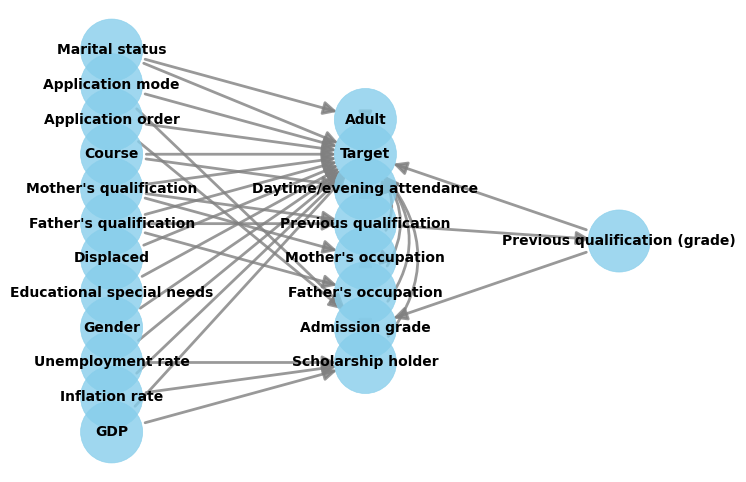


Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                              
────────(E[Target|Marital status])
d[Adult]                          
Estimand assumption 1, Unconfoundedness: If U→{Adult} and U→Target then P(Target|Adult,Marital status,U) = P(Target|Adult,Marital status)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Estimated ATE using Propensity Score Matching: -0.5773123087785361

Estimated ATE using Doubly Robust Estimator: -0.19811009498386545

Refutation Results:
Refute: Use a Placebo Treatment
Estimated effect:-0.19811009498386545
New effect:0.07911710341487295
p value:0.0



In [19]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


df = list(dfs.values())[0]
causal_graph = model_edges["gpt-o4"]

# Create a CausalModel
model = CausalModel(
    data=df,
    treatment="Adult",
    outcome="Target",
    graph=causal_graph
)

# Visualize the causal DAG
model.view_model()
plt.show()

# Identify the causal effect using the backdoor criterion
identified_estimand = model.identify_effect()
print("\nIdentified Estimand:")
print(identified_estimand)

# Different estimation methods
methods = {
    "Propensity Score Matching": "backdoor.propensity_score_matching",
    "Doubly Robust Estimator": "backdoor.propensity_score_weighting"
}

# Estimate ATE using different methods
for method_name, method in methods.items():
    if method_name == "Logistic Regression":
        estimate = model.estimate_effect(identified_estimand,method_name=method, method_params = {
                                            'fit_method': "statsmodels",
                                            'glm_family': sm.families.Binomial() #logistic 
                                        })
    else:
        estimate = model.estimate_effect(identified_estimand, method_name=method)
    print(f"\nEstimated ATE using {method_name}: {estimate.value}")

# Refutation test: Placebo treatment
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print("\nRefutation Results:")
print(refutation)


### Generalized Experiment

In [20]:
import dowhy
from dowhy import CausalModel
import pandas as pd 
import numpy as np
import statsmodels.api as sm  # Ensure statsmodels is imported
from tqdm import tqdm

# Initialize results list
results = []

# Define estimation methods
methods = {
   # "PSS": "backdoor.propensity_score_stratification",
    "PSM": "backdoor.propensity_score_matching",
    "IPW": "backdoor.propensity_score_weighting",
   # "SIPW": "backdoor.propensity_score_weighting"
   # "LR" : "backdoor.generalized_linear_model"
}

num_sim = 50  # Number of bootstrap simulations
max_iter = 1000

# Iterate over datasets
for df_name, df in tqdm(dfs.items()):
    print(df_name)
    #print(df.head(5))
    title_words = df_name.split('_')
    adult_thresh = title_words[2]
    outcome_def = title_words[4].split('.')[0]

    # Iterate over different causal graphs
    for LM_model, cg in model_edges.items():

        print(LM_model)
        # if LM_model != "gpt-o4":
        #     continue
        #print(LM_model)
        
        # Create a CausalModel
        model = CausalModel(
            data=df,
            treatment="Adult",
            outcome="Target",
            graph=cg
        )
        
        # Identify the causal effect using the backdoor criterion
        identified_estimand = model.identify_effect()

        # Iterate over different estimation methods
        for method_name, method in tqdm(methods.items(),desc = "method"):
            print(method_name)

            if LM_model == "gpt-o4" and method_name == "LR":
                continue

            method_params = {'num_simulations': num_sim, 'max_iter': max_iter}
            if method_name == "LR":
                method_params = {'num_simulations': num_sim, 'max_iter': max_iter, 'glm_family': sm.families.Gaussian()}
            elif method_name == "IPW":
                method_params = {'num_simulations': num_sim, 'max_iter': max_iter, 'weighting_scheme': "ips_weight"}
            elif method_name == "SIPW":
                method_params = {'num_simulations': num_sim, 'max_iter': max_iter, 'weighting_scheme': "ips_stabilized_weight"}
            
            bootstrap_results = model.estimate_effect(
                identified_estimand,
                method_name=method,
                method_params= method_params
            )

            # bootstrap_results = model.refute_estimate(
            #     identified_estimand, estimate, method_name="bootstrap_refuter",
            #     method_params={"num_simulations": num_sim}
            # )
                
            # Extract ATE value
            ate_value = bootstrap_results.value
            
            #print(bootstrap_results.get_confidence_intervals(confidence_level=0.95))
            CI = bootstrap_results.get_confidence_intervals(confidence_level=0.95)
            #print("yp")
            
            
            # Append results
            results.append({
                "Adult_Threshold": adult_thresh,
                "Outcome_Definition": outcome_def,
                "Method": method_name,
                "GC_Model": LM_model,
                "ATE": ate_value,
                "95%_Bootstrap_CI": CI
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv("results/ate_results_dowhy.csv", index=False)
results_df.head(5)

  0%|          | 0/6 [00:00<?, ?it/s]

processed_age_20_outcome_inclusive.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


gpt-o4


PSM


IPW


 17%|█▋        | 1/6 [00:07<00:36,  7.21s/it]

processed_age_21_outcome_strict.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


gpt-o4


PSM


IPW


 33%|███▎      | 2/6 [00:11<00:22,  5.56s/it]

processed_age_20_outcome_strict.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


gpt-o4


PSM


IPW


 50%|█████     | 3/6 [00:15<00:14,  4.99s/it]

processed_age_23_outcome_inclusive.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


gpt-o4


PSM


IPW


 67%|██████▋   | 4/6 [00:20<00:09,  4.67s/it]

processed_age_21_outcome_inclusive.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


gpt-o4


PSM


IPW


 83%|████████▎ | 5/6 [00:24<00:04,  4.48s/it]

processed_age_23_outcome_strict.csv
gpt-o3-mini-high


PSM


IPW


method: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


gpt-o1


PSM


IPW


method: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


gpt-o4


PSM


IPW


100%|██████████| 6/6 [00:28<00:00,  4.75s/it]


,Adult_Threshold,Outcome_Definition,Method,GC_Model,ATE,95%_Bootstrap_CI
0,20,inclusive,PSM,gpt-o3-mini-high,-0.576842,"(-1.4718757354671688, -0.5662508825606026)"
1,20,inclusive,IPW,gpt-o3-mini-high,-0.198110,"(-0.21961342362591252, -0.1724001189967096)"
2,20,inclusive,PSM,gpt-o1,-0.576842,"(-1.4624617557072255, -0.567192280536597)"
3,20,inclusive,IPW,gpt-o1,-0.198110,"(-0.22191619885224123, -0.17015878351586722)"
4,20,inclusive,PSM,gpt-o4,-0.576842,"(-1.4570487173452578, -0.567192280536597)"


### Plots

In [21]:
results_df.head(100)

,Adult_Threshold,Outcome_Definition,Method,GC_Model,ATE,95%_Bootstrap_CI
0,20,inclusive,PSM,gpt-o3-mini-high,-0.576842,"(-1.4718757354671688, -0.5662508825606026)"
1,20,inclusive,IPW,gpt-o3-mini-high,-0.198110,"(-0.21961342362591252, -0.1724001189967096)"
2,20,inclusive,PSM,gpt-o1,-0.576842,"(-1.4624617557072255, -0.567192280536597)"
3,20,inclusive,IPW,gpt-o1,-0.198110,"(-0.22191619885224123, -0.17015878351586722)"
4,20,inclusive,PSM,gpt-o4,-0.576842,"(-1.4570487173452578, -0.567192280536597)"
5,20,inclusive,IPW,gpt-o4,-0.198110,"(-0.21870855936237743, -0.17863828640568347)"
6,21,strict,PSM,gpt-o3-mini-high,-0.185220,"(-0.2398211343845611, -0.12379383384325726)"
7,21,strict,IPW,gpt-o3-mini-high,-0.165061,"(-0.2020627030756098, -0.13558910581733968)"
8,21,strict,PSM,gpt-o1,-0.185455,"(-0.23228995057660629, -0.13720875500117677)"
9,21,strict,IPW,gpt-o1,-0.165061,"(-0.19306554949192872, -0.13843436928476455)"


Configuration- ATE Histogram

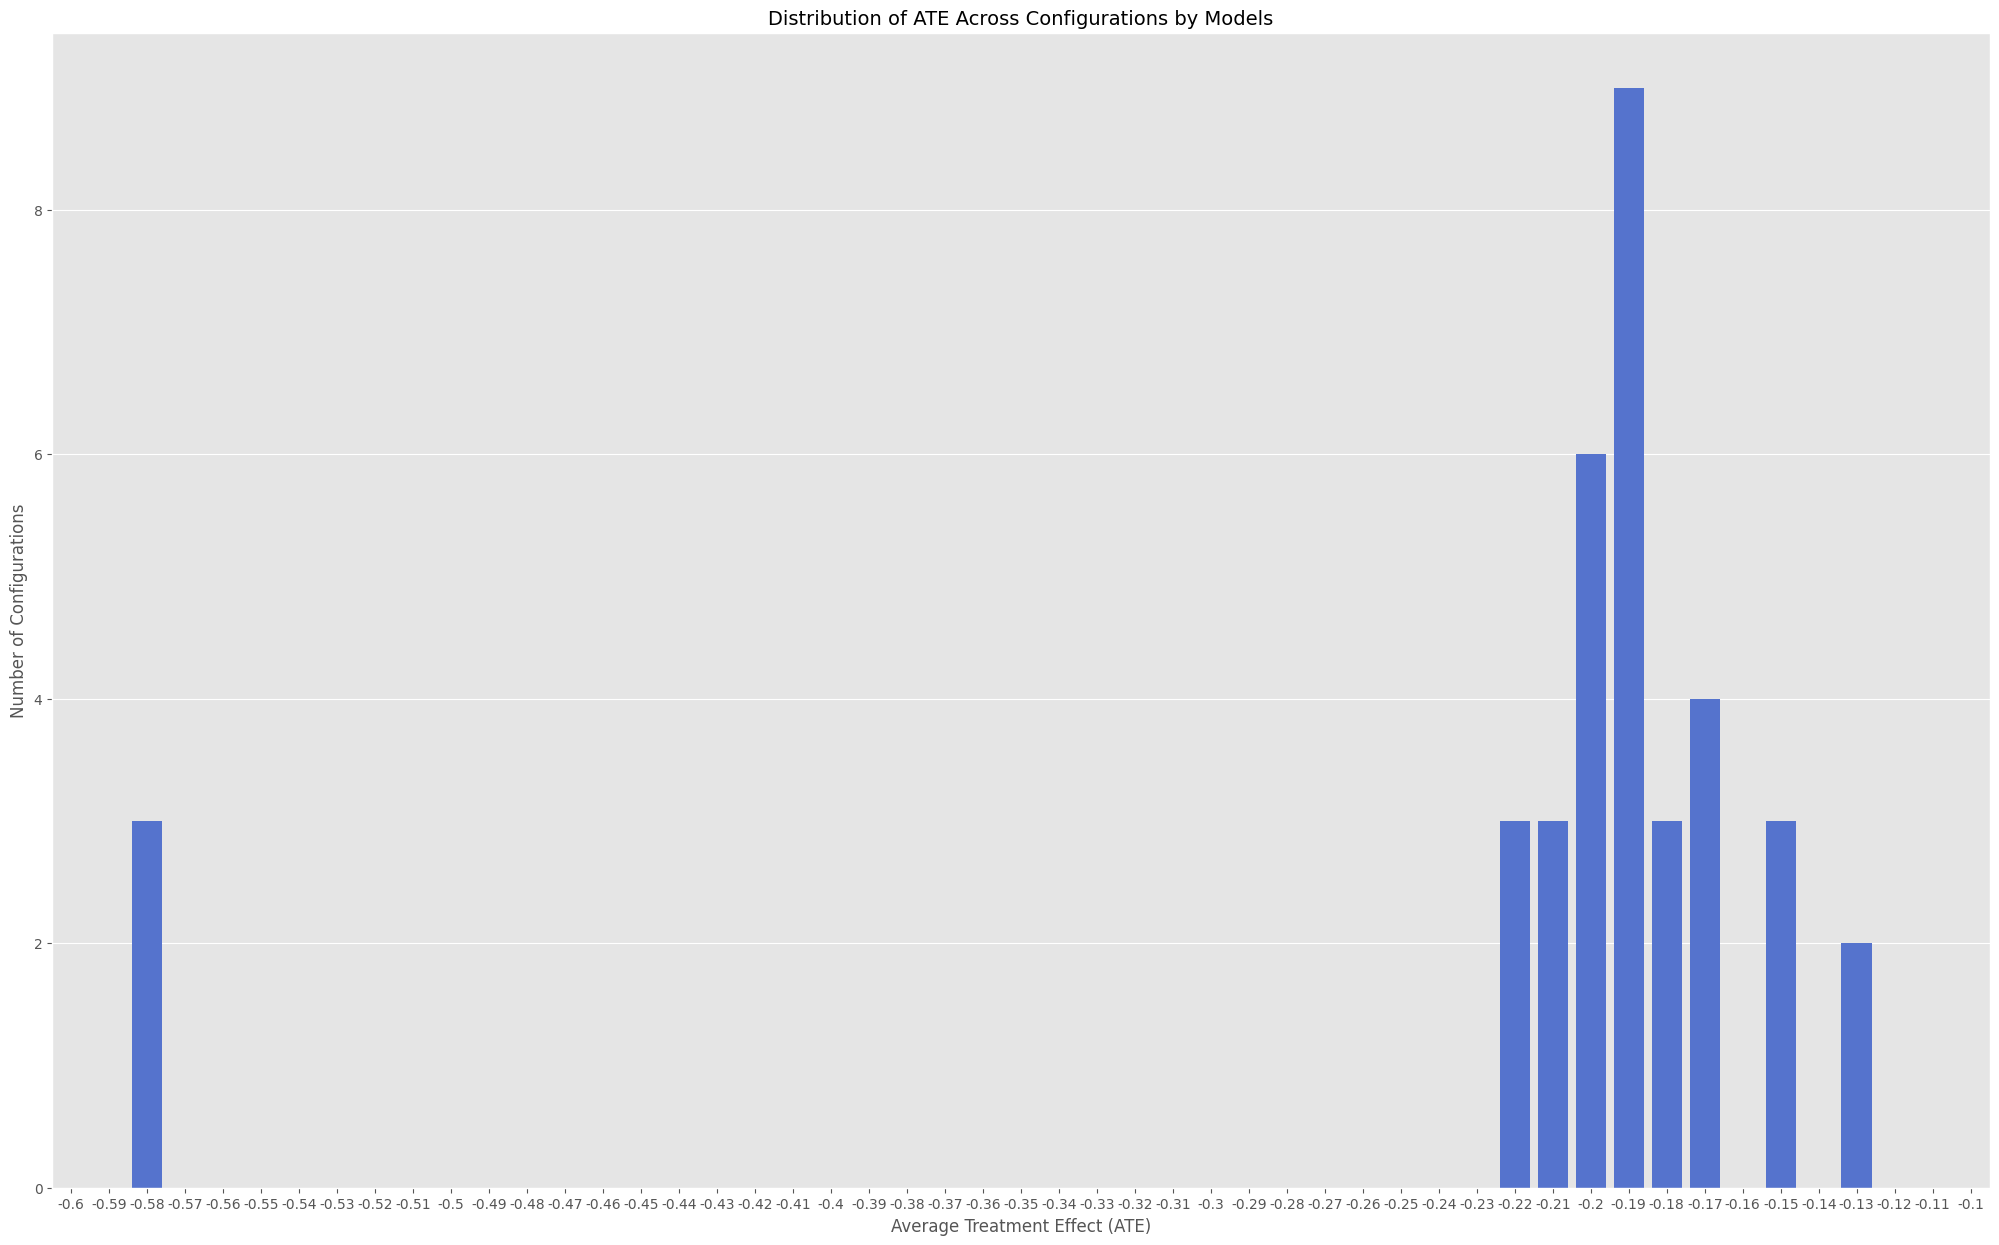

In [22]:
# Load data
file_path = "results/ate_results_dowhy.csv"
results_df = pd.read_csv(file_path)

# Extract ATE values and round them to two decimal places
ate_values = results_df["ATE"].round(2)

# Count occurrences of each ATE value
ate_counts = Counter(ate_values)

# Convert to lists for plotting
unique_ates = list(ate_counts.keys())
counts = list(ate_counts.values())

# Define the full range of ATE values with 0.01 increments
ate_range = np.round(np.arange(-0.6, -0.09, 0.01), 2)
for ate in ate_range:
    if ate not in unique_ates:
        unique_ates.append(ate)
        counts.append(0)

# Plot the bar chart
plt.figure(figsize=(25, 15))
sns.barplot(x=unique_ates, y=counts, color="royalblue")

plt.xlabel("Average Treatment Effect (ATE)",fontsize = 12)
plt.ylabel("Number of Configurations",fontsize = 12)
plt.title("Distribution of ATE Across Configurations by Models", fontsize=14)


# Show the plot
plt.show()


Config - ATE Partitioned by Models

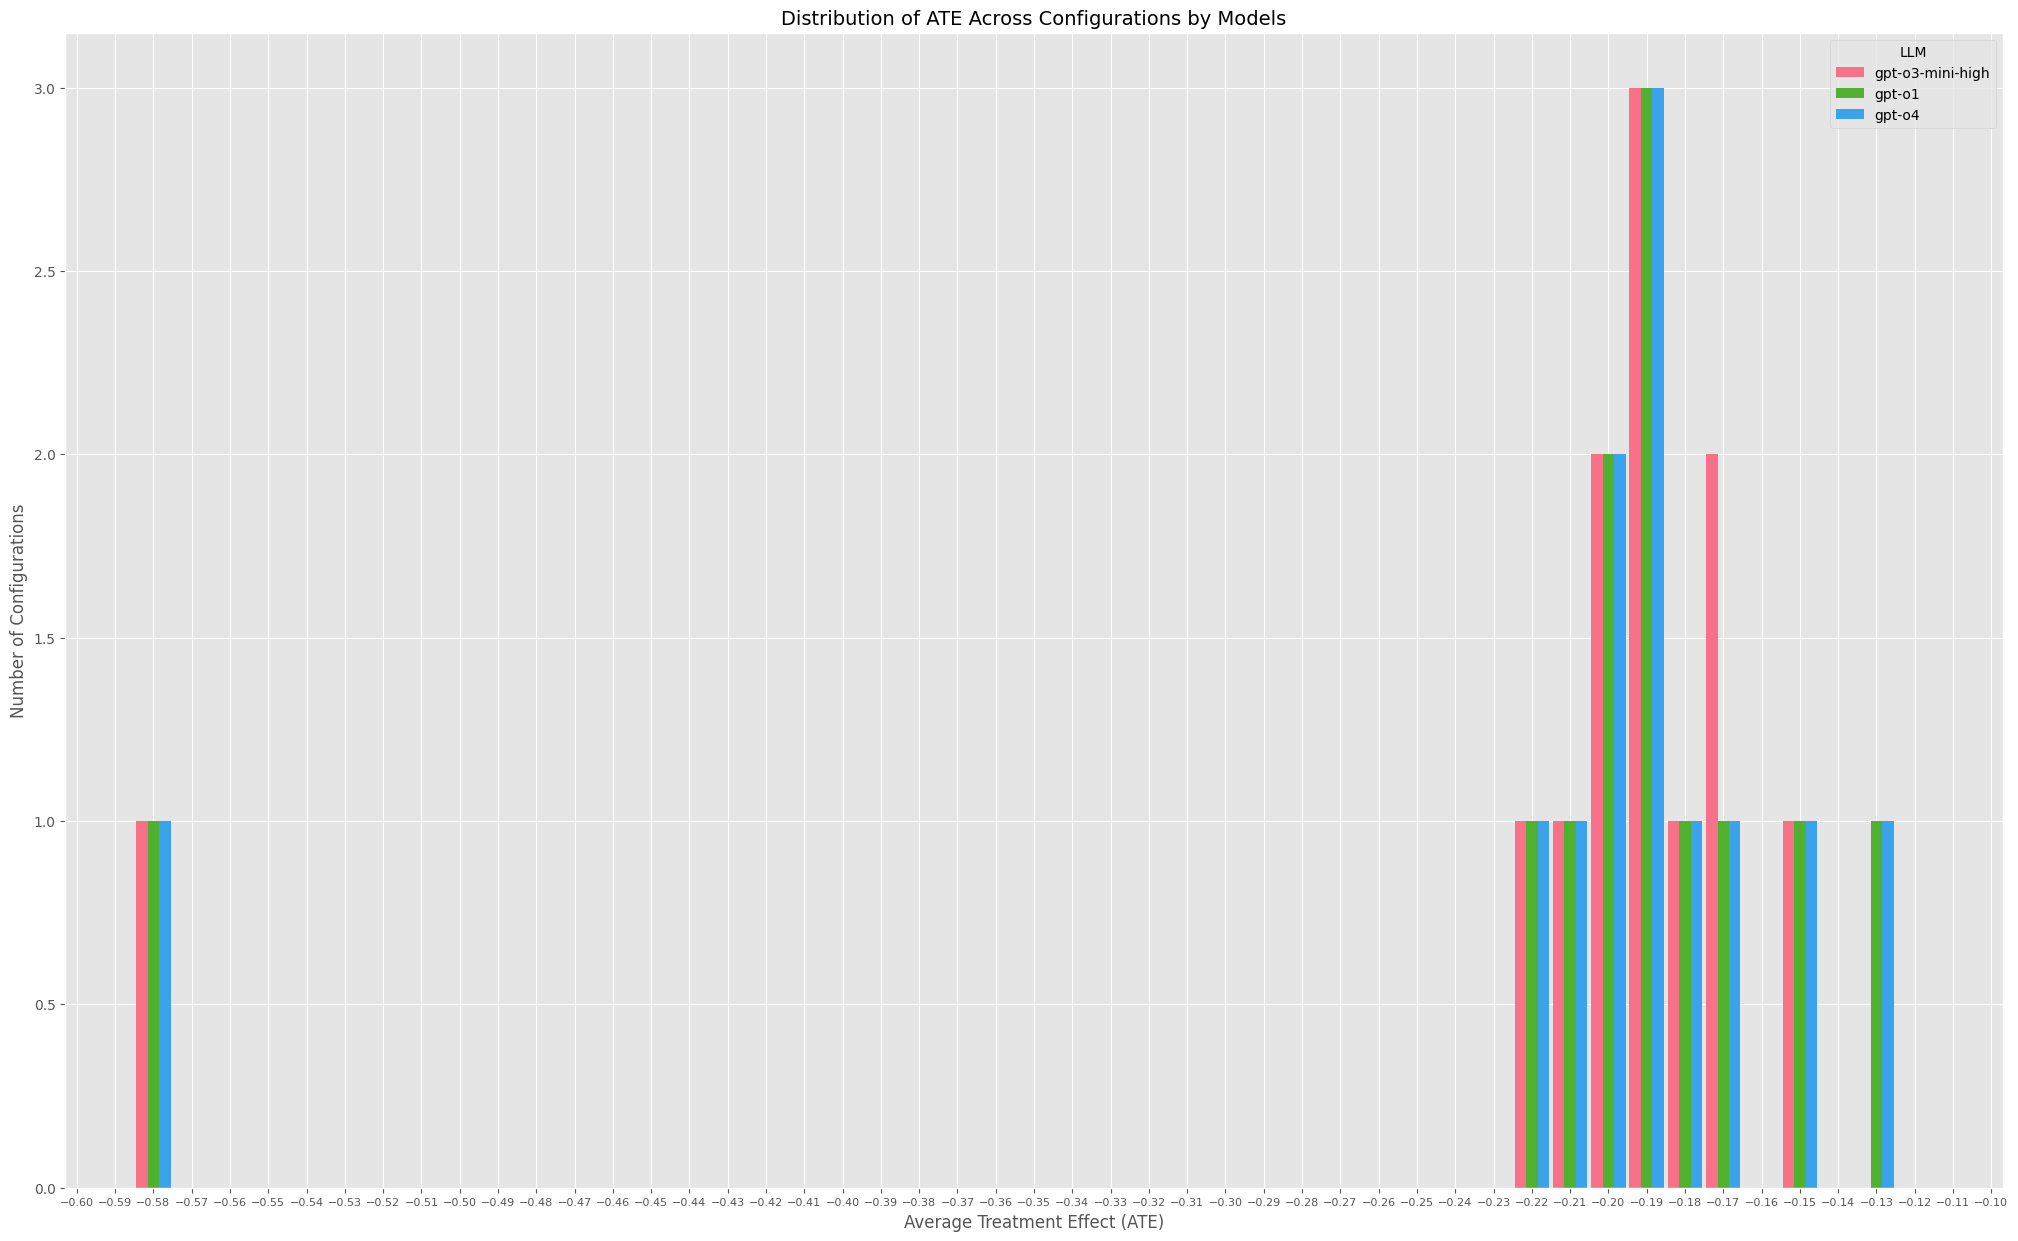

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter

# Load data
file_path = "results/ate_results_dowhy.csv"
results_df = pd.read_csv(file_path)

# Extract unique models
models = results_df["GC_Model"].unique()
num_models = len(models)
bar_width = 0.009 / num_models  # Divide bar width to fit models side by side

# Define the full range of ATE values with 0.01 increments
ate_range = np.round(np.arange(-0.6, -0.09, 0.01), 2)

# Create lists to store data for plotting
unique_ates = list(ate_range)  # Ensure the x-axis has all required values
counts_by_model = {model: [] for model in models}

# Count occurrences of each ATE value for each model
for model in models:
    model_ate_values = results_df[results_df["GC_Model"] == model]["ATE"].round(2)
    model_ate_counts = Counter(model_ate_values)

    # Ensure every ATE value in the range is included
    counts_by_model[model] = [model_ate_counts.get(ate, 0) for ate in ate_range]

# Create the figure
plt.figure(figsize=(25, 15))

# Colors for different models
colors = sns.color_palette("husl", num_models)

# Plot bars for each model separately, shifting them along the x-axis
for i, (model, color) in enumerate(zip(models, colors)):
    plt.bar(np.array(unique_ates) + (i - (num_models - 1) / 2) * bar_width, 
            counts_by_model[model], 
            color=color, 
            width=bar_width, 
            label=model)

# Labels and title
plt.xlabel("Average Treatment Effect (ATE)", fontsize=12)
plt.ylabel("Number of Configurations", fontsize=12)
plt.title("Distribution of ATE Across Configurations by Models", fontsize=14)

# Set x-axis limits to remove empty space
plt.xlim(min(unique_ates) - bar_width, max(unique_ates) + bar_width)

# Set x-axis ticks to show every ATE value in steps of 0.01 
plt.xticks(unique_ates, fontsize=8)

# Add legend
plt.legend(title="LLM")

# Show the plot
plt.show()


Per Method

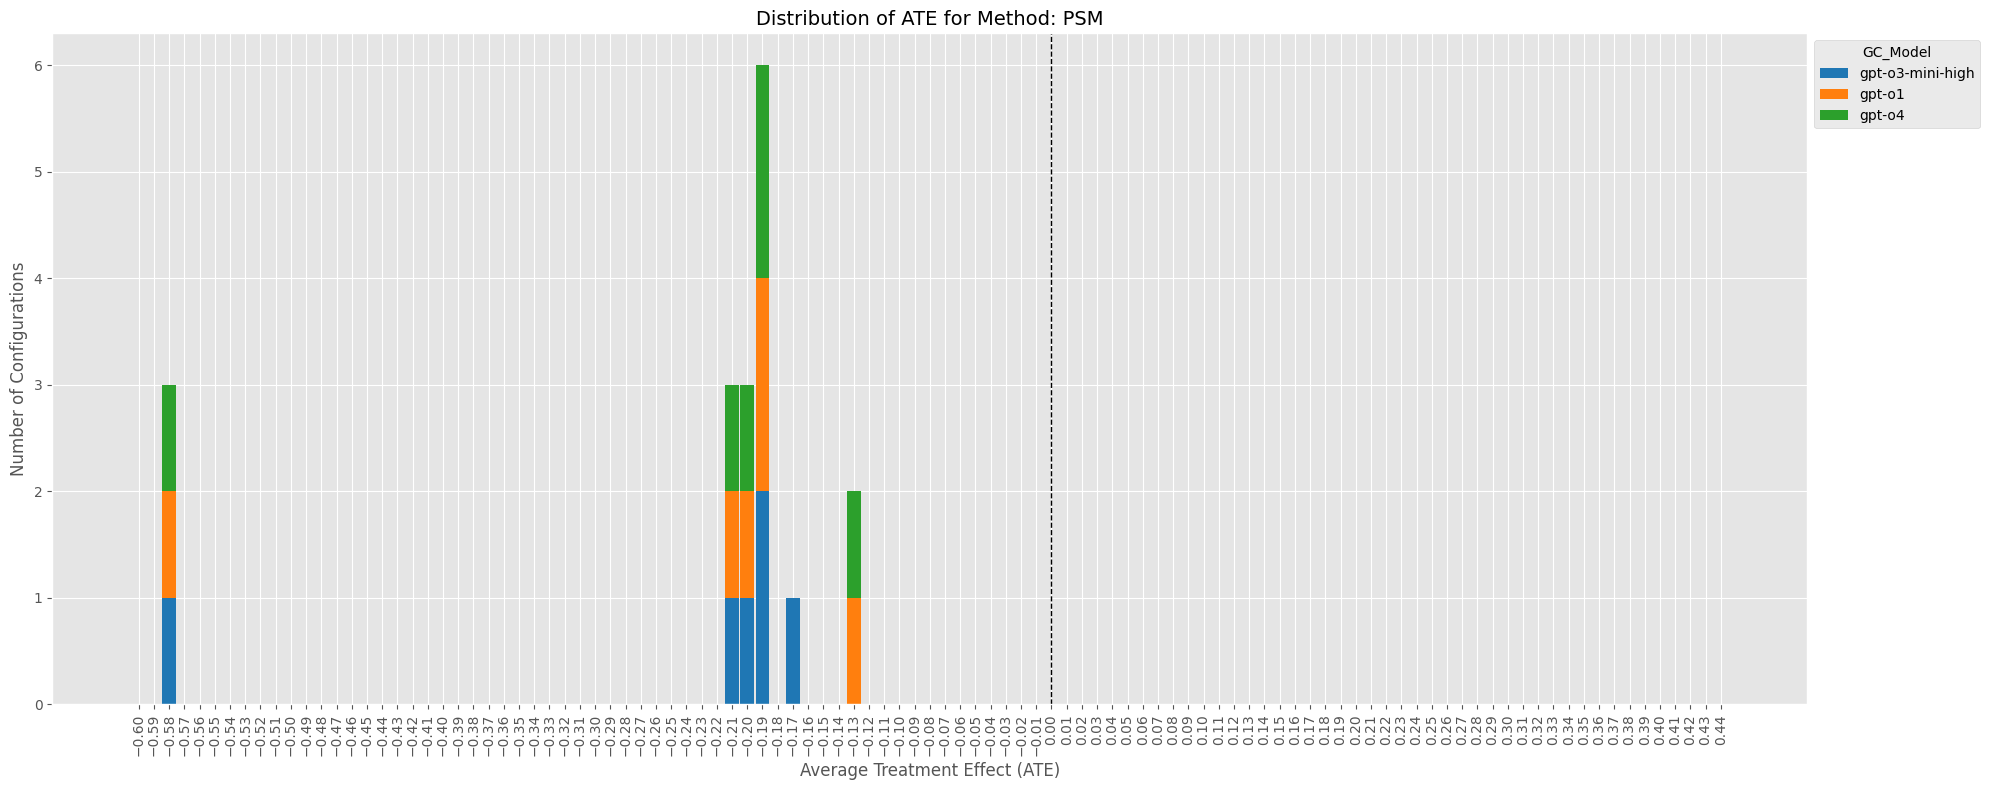

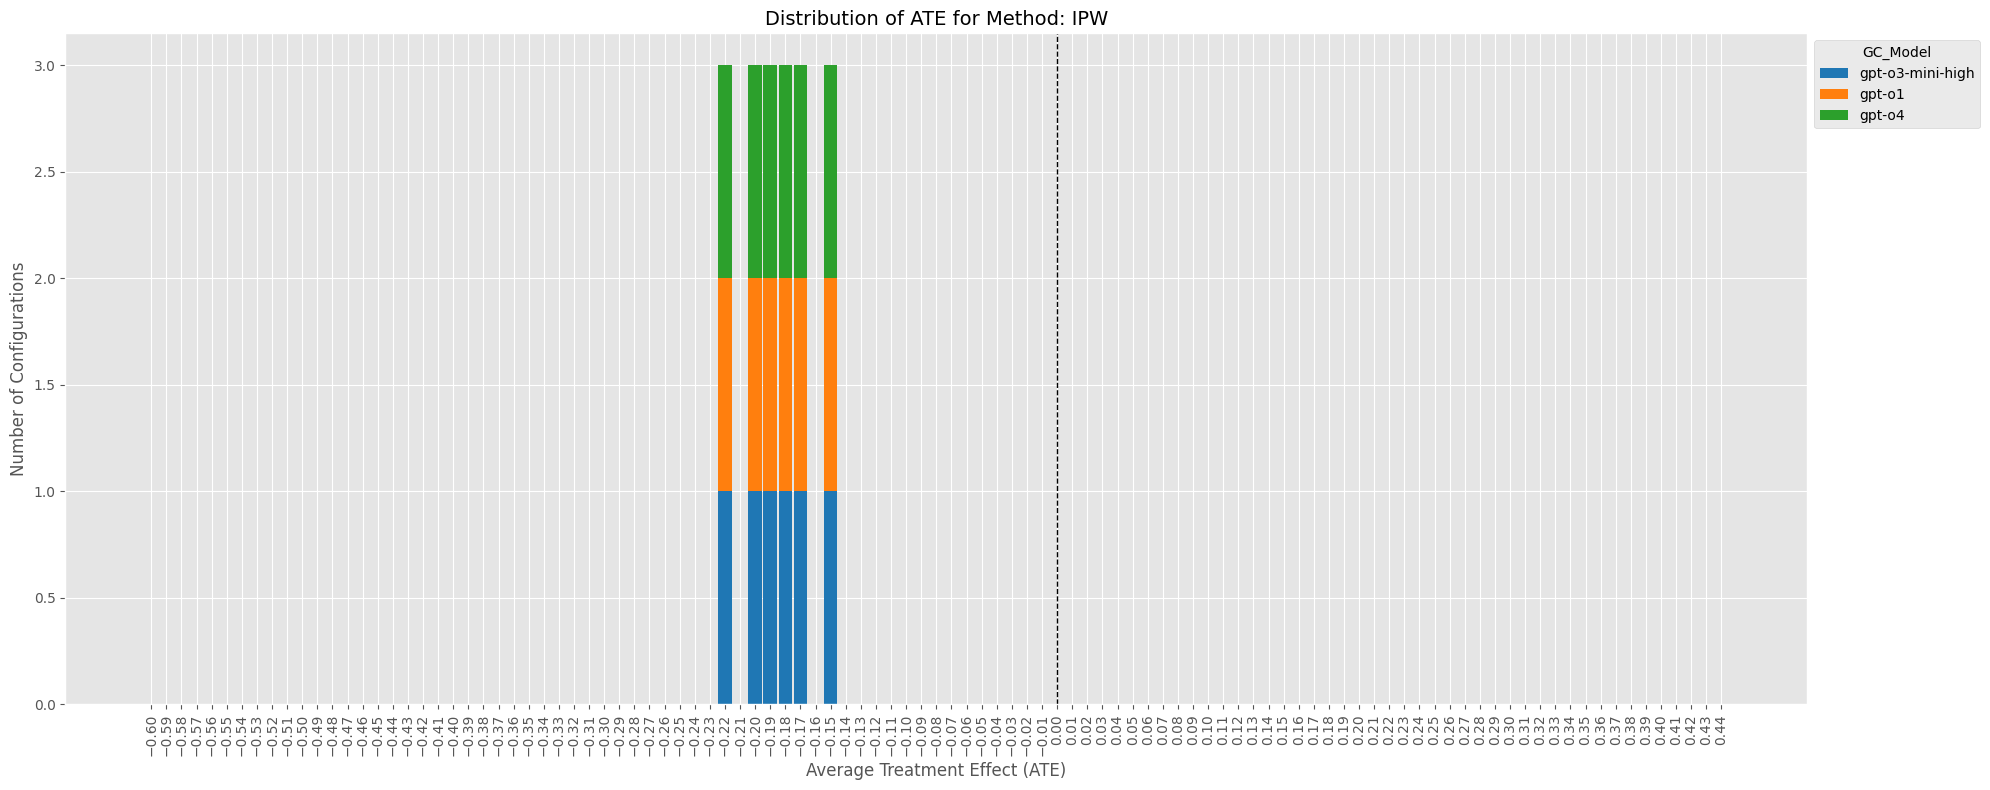

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the ATE range with 0.01 increments
ate_range = np.round(np.arange(-0.6, 0.45, 0.01), 2)

# Extract unique methods
methods = results_df["Method"].unique()

# Iterate over each method
for method in methods:
    plt.figure(figsize=(20, 8))
    
    # Filter data for the current method
    method_df = results_df[results_df["Method"] == method]
    
    # Extract unique models within this method
    models = method_df["GC_Model"].unique()
    
    # Initialize dictionary to store counts
    ate_counts_by_model = {model: np.zeros(len(ate_range)) for model in models}
    
    # Count occurrences for each model
    for model in models:
        model_data = method_df.loc[method_df["GC_Model"] == model, "ATE"].dropna().round(2)
        model_counts = model_data.value_counts().reindex(ate_range, fill_value=0).sort_index()
        ate_counts_by_model[model] = model_counts.values

    # Stack the histogram by model
    bottom_counts = np.zeros(len(ate_range))
    colors = sns.color_palette("tab10", len(models))

    for model, color in zip(models, colors):
        plt.bar(ate_range, ate_counts_by_model[model], color=color, width=0.009, label=model, bottom=bottom_counts)
        bottom_counts += ate_counts_by_model[model]

    # Mark ATE = 0 with a dashed line
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Average Treatment Effect (ATE)", fontsize=12)
    plt.ylabel("Number of Configurations", fontsize=12)
    plt.title(f"Distribution of ATE for Method: {method}", fontsize=14)

    # Set x-axis ticks every 0.1 for readability
    plt.xticks(np.arange(-0.6, 0.45, 0.01), rotation=90, fontsize=10)

    # Add legend outside plot
    plt.legend(title="GC_Model", loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

Per Threshold

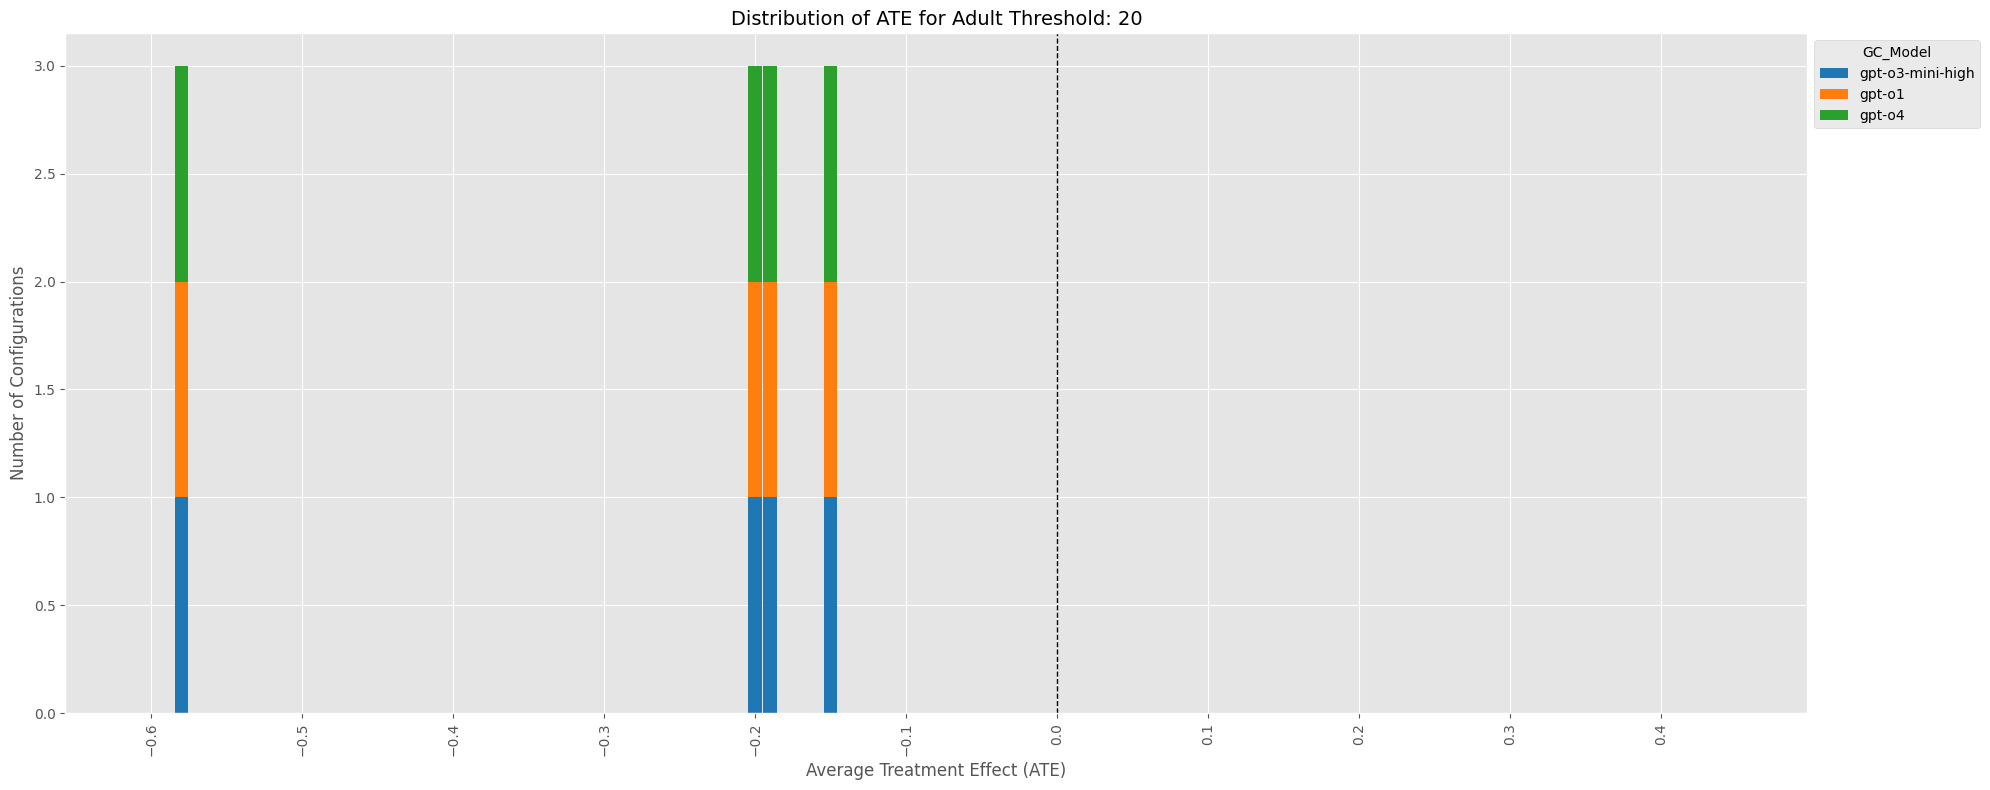

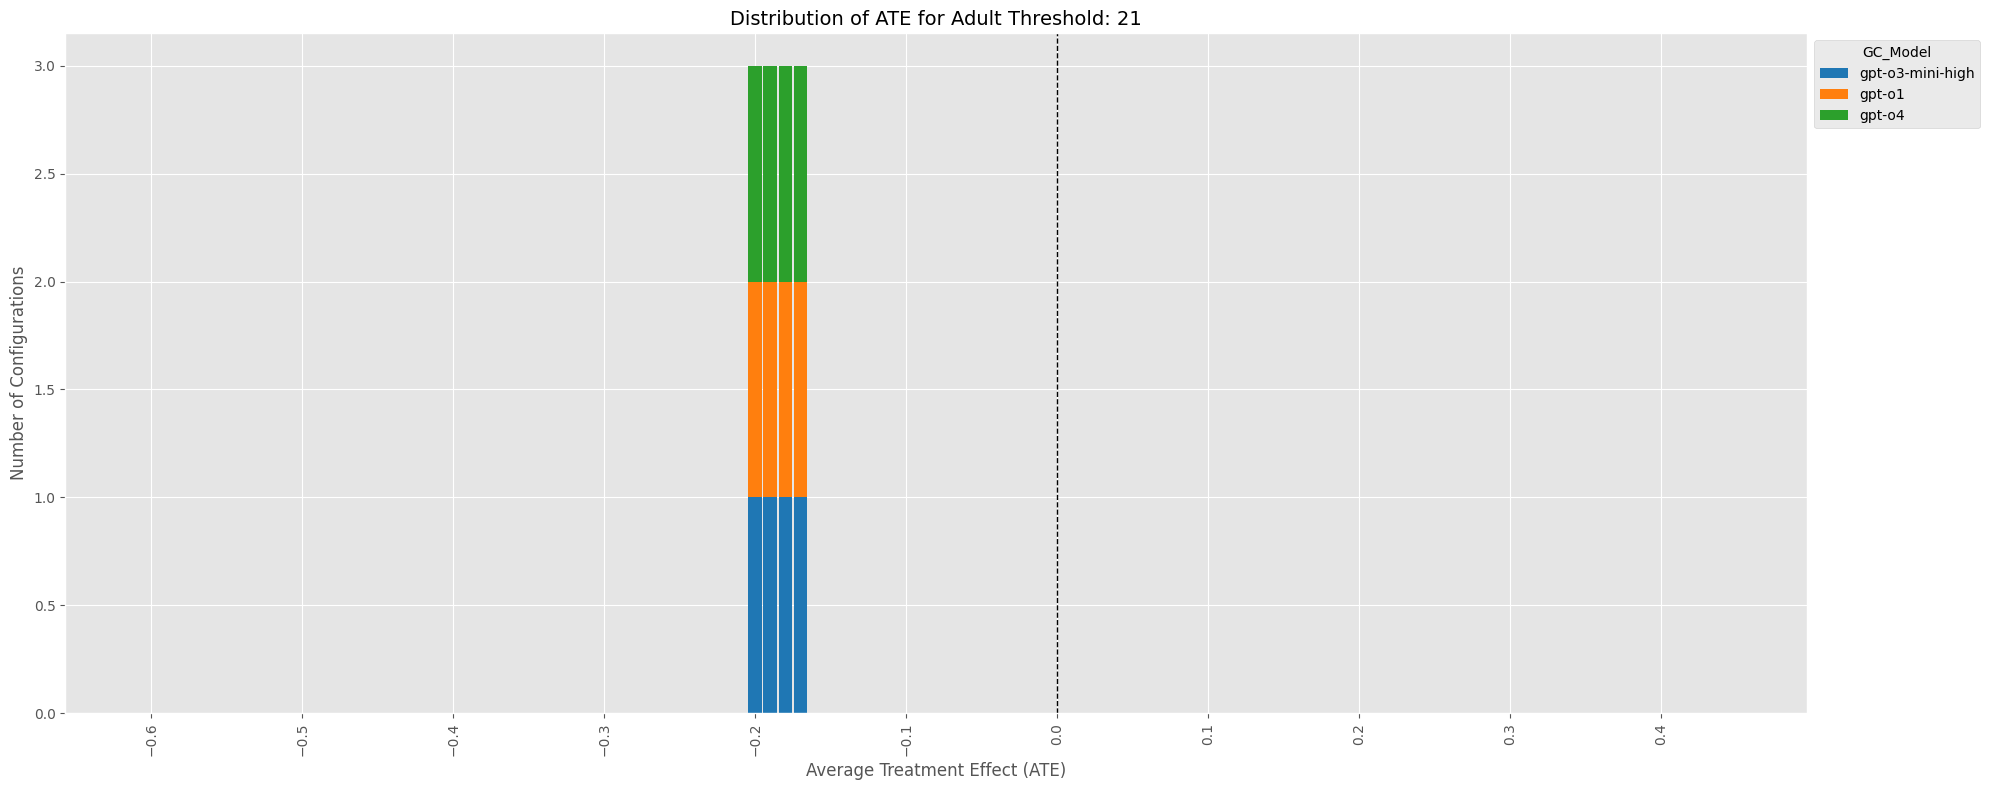

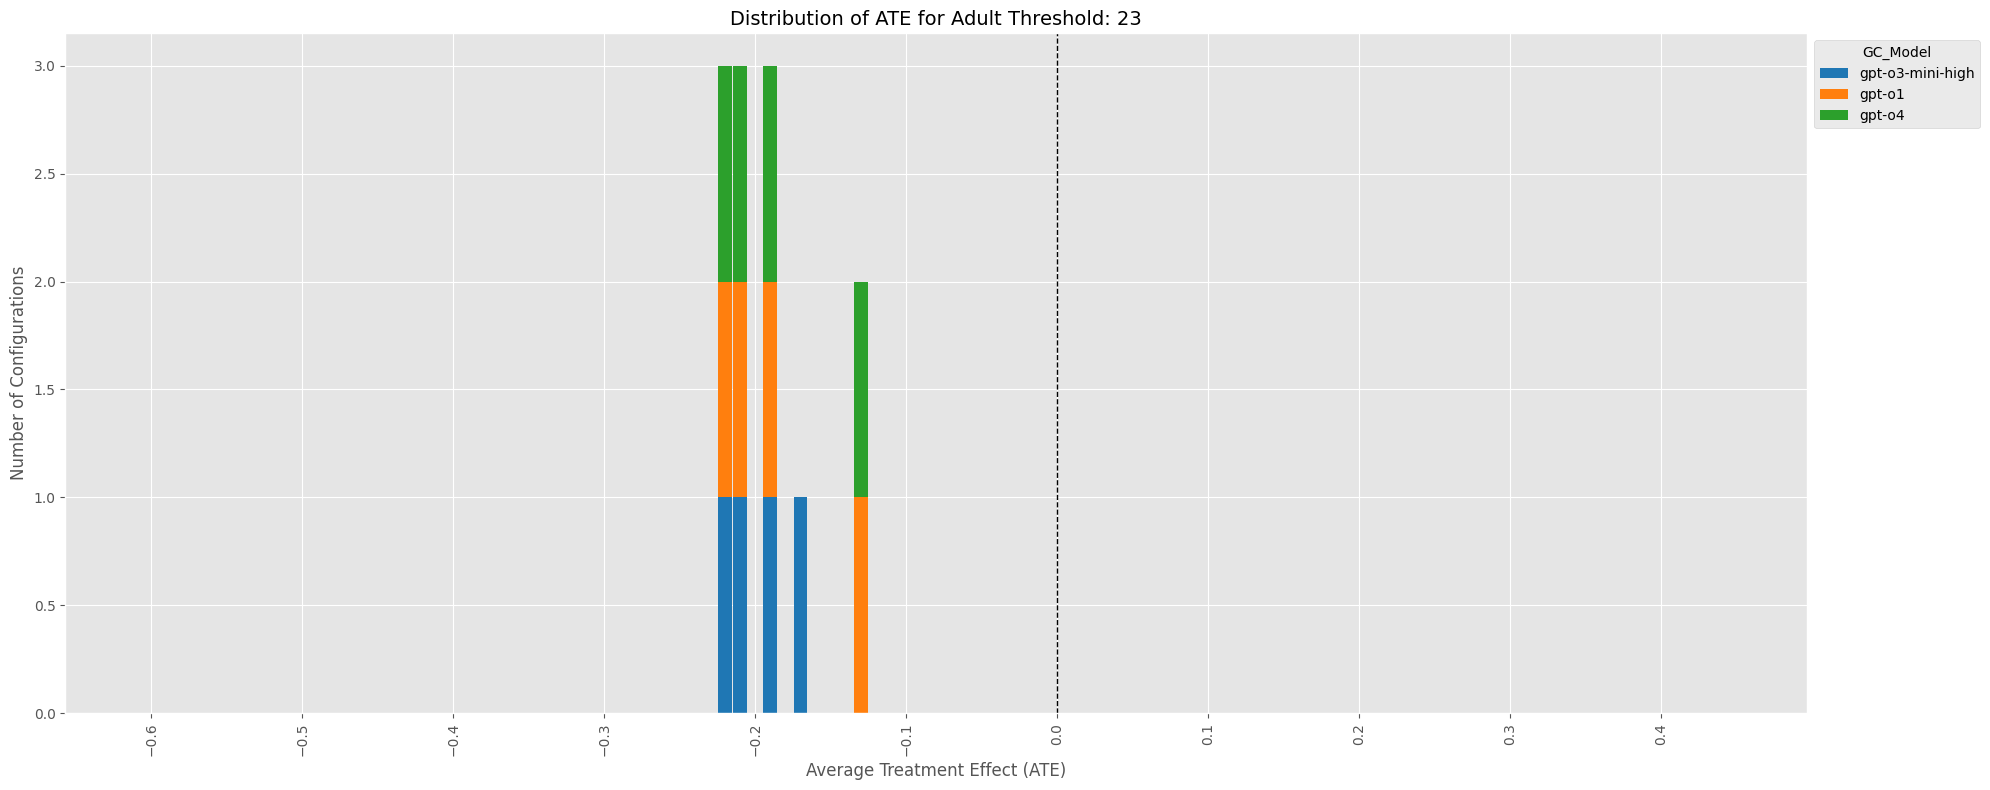

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the ATE range with 0.01 increments
ate_range = np.round(np.arange(-0.6, 0.45, 0.01), 2)

# Extract unique adult thresholds
adult_thresholds = results_df["Adult_Threshold"].unique()

# Iterate over each adult threshold
for threshold in adult_thresholds:
    plt.figure(figsize=(20, 8))
    
    # Filter data for the current threshold
    threshold_df = results_df[results_df["Adult_Threshold"] == threshold]
    
    # Extract unique models within this threshold
    models = threshold_df["GC_Model"].unique()
    
    # Initialize dictionary to store counts
    ate_counts_by_model = {model: np.zeros(len(ate_range)) for model in models}
    
    # Count occurrences for each model
    for model in models:
        model_data = threshold_df.loc[threshold_df["GC_Model"] == model, "ATE"].dropna().round(2)
        model_counts = model_data.value_counts().reindex(ate_range, fill_value=0).sort_index()
        ate_counts_by_model[model] = model_counts.values

    # Stack the histogram by model
    bottom_counts = np.zeros(len(ate_range))
    colors = sns.color_palette("tab10", len(models))

    for model, color in zip(models, colors):
        plt.bar(ate_range, ate_counts_by_model[model], color=color, width=0.009, label=model, bottom=bottom_counts)
        bottom_counts += ate_counts_by_model[model]

    # Mark ATE = 0 with a dashed line
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Average Treatment Effect (ATE)", fontsize=12)
    plt.ylabel("Number of Configurations", fontsize=12)
    plt.title(f"Distribution of ATE for Adult Threshold: {threshold}", fontsize=14)

    # Set x-axis ticks every 0.1 for readability
    plt.xticks(np.arange(-0.6, 0.45, 0.1), rotation=90, fontsize=10)

    # Add legend outside plot
    plt.legend(title="GC_Model", loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


Strict vs Inclusive

['inclusive' 'strict']


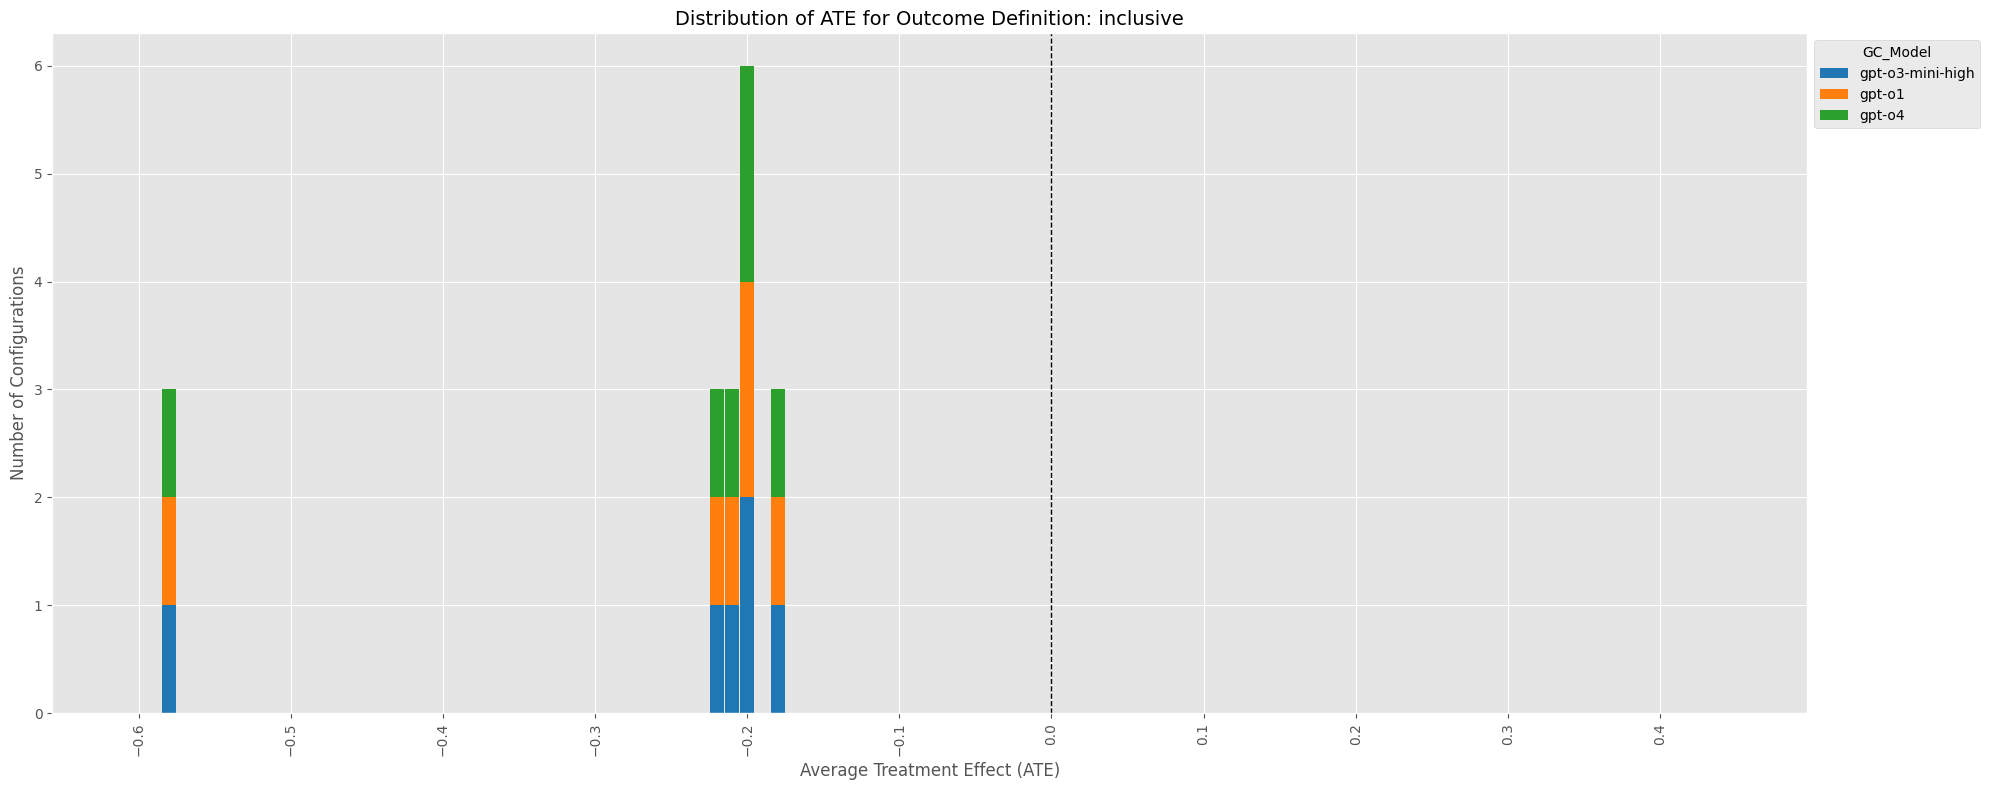

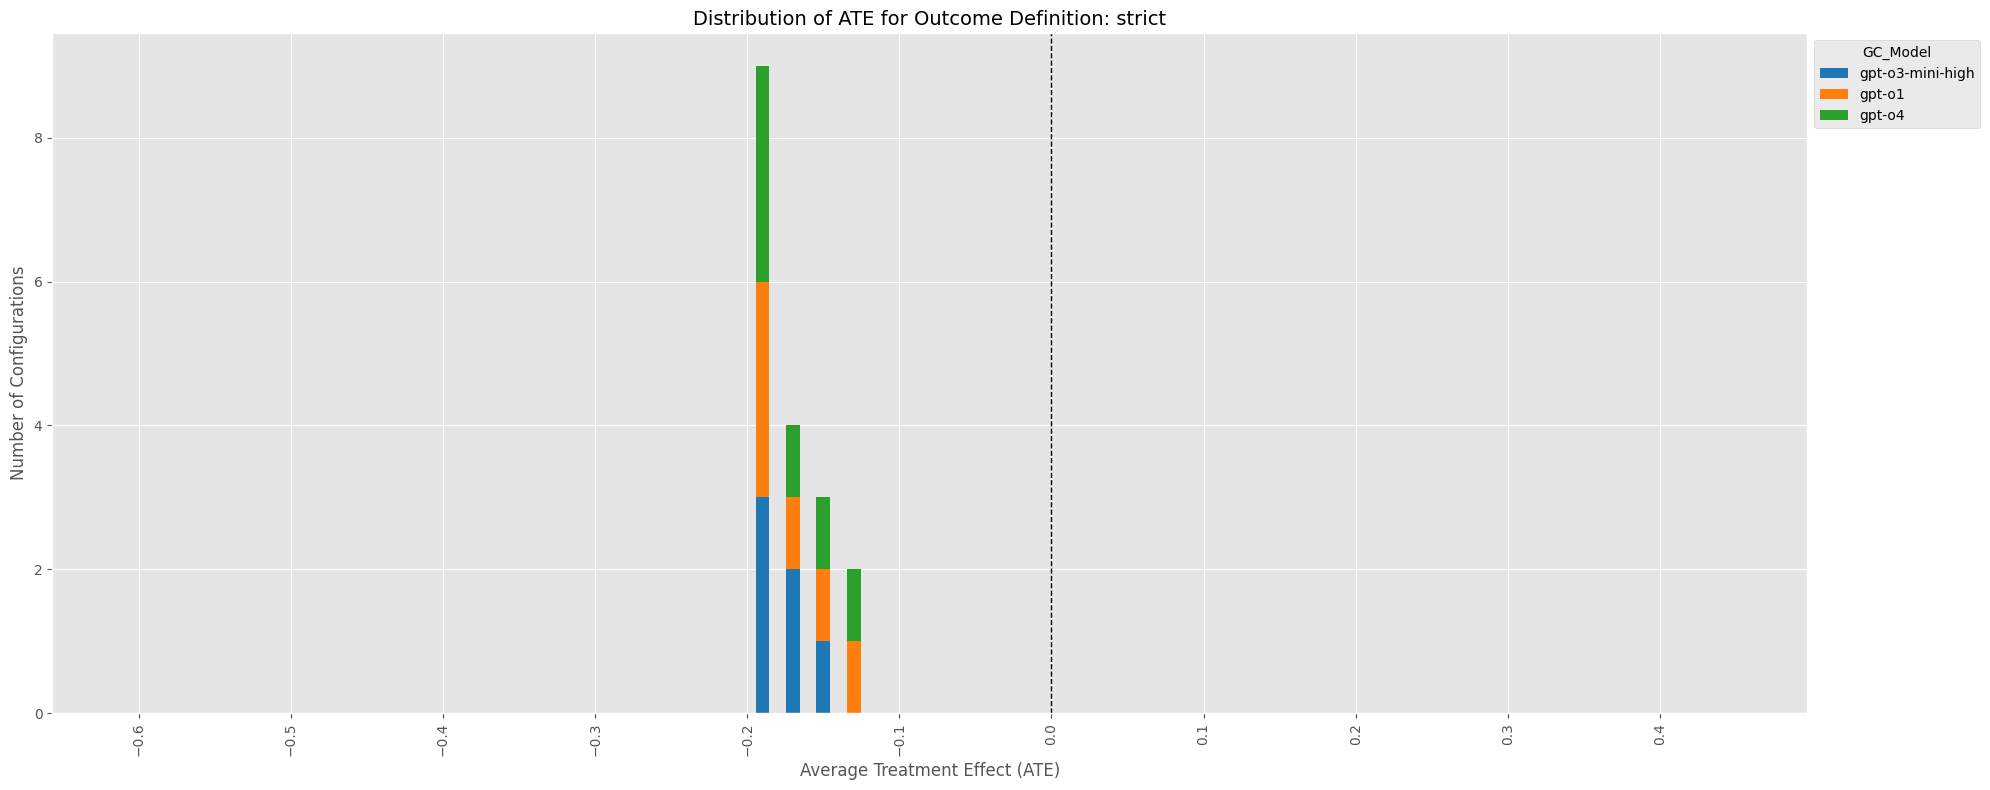

In [26]:
# Extract unique outcome definitions (Strict vs Inclusive)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the ATE range with 0.01 increments
ate_range = np.round(np.arange(-0.6, 0.45, 0.01), 2)

# Extract unique outcome definitions (Strict vs Inclusive)
outcome_definitions = results_df["Outcome_Definition"].unique()
print(outcome_definitions)

# Iterate over each outcome definition
for outcome in outcome_definitions:
    plt.figure(figsize=(20, 8))
    
    # Filter data for the current outcome definition
    outcome_df = results_df[results_df["Outcome_Definition"] == outcome]
    
    # Extract unique models within this outcome definition
    models = outcome_df["GC_Model"].unique()
    
    # Initialize dictionary to store counts
    ate_counts_by_model = {model: np.zeros(len(ate_range)) for model in models}
    
    # Count occurrences for each model
    for model in models:
        model_data = outcome_df.loc[outcome_df["GC_Model"] == model, "ATE"].dropna().round(2)
        model_counts = model_data.value_counts().reindex(ate_range, fill_value=0).sort_index()
        ate_counts_by_model[model] = model_counts.values

    # Stack the histogram by model
    bottom_counts = np.zeros(len(ate_range))
    colors = sns.color_palette("tab10", len(models))

    for model, color in zip(models, colors):
        plt.bar(ate_range, ate_counts_by_model[model], color=color, width=0.009, label=model, bottom=bottom_counts)
        bottom_counts += ate_counts_by_model[model]

    # Mark ATE = 0 with a dashed line
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Average Treatment Effect (ATE)", fontsize=12)
    plt.ylabel("Number of Configurations", fontsize=12)
    plt.title(f"Distribution of ATE for Outcome Definition: {outcome}", fontsize=14)

    # Set x-axis ticks every 0.1 for readability
    plt.xticks(np.arange(-0.6, 0.45, 0.1), rotation=90, fontsize=10)

    # Add legend outside plot
    plt.legend(title="GC_Model", loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
